In [63]:
import numpy as np
import matplotlib.pyplot as plt
from IPython import display
import time
import scipy.integrate as intg
%matplotlib inline

# COmment on distinguishability of particles
# Check boundary conditions once more
# Check application of potential

def tdse(u_2, v_2, m1, m2, dt, dx, T_array, V, title):
    
    # initialization
    L = u_2.shape[0]
    M = u_2.shape[1]
    N = int(T_array.max())
    lmbd = dt/(dx**2)
    
    u_1 = u_2
    u = u_2
    v_1 = v_2
    v = v_2
    mzeros = np.zeros(M)
    lzeros = np.zeros(L)
    
    xs = np.arange(L)*dx
    la = xs.copy()
    ma = np.arange(M)*dx
    la, ma = np.meshgrid(la, ma)
    Va = V(la, ma) # think V0*exp(-np.abs(la-ma)/(2*alpha**2))
    
    fm = (((1/m1)+(1/m2))*4*lmbd + dt*Va)[1:-1,1:-1]
    
    splts = int(np.sqrt(T_array.size))
    fig = plt.figure(figsize = (splts*3,splts*3))
    tmp = 1
    
    # main loop
    for n in range(N+1):
        u[1:-1,1:-1] = u_2[1:-1,1:-1] + 2*(fm*v_1[1:-1,1:-1]
                    - lmbd *((v_1[2:,1:-1]
                            +v_1[:-2,1:-1])/m1
                            +(v_1[1:-1,2:]
                            +v_1[1:-1,:-2])/m2))
        u[0,:] = mzeros
        u[-1,:] = mzeros
        u[:,0] = lzeros
        u[:,-1] = lzeros
        v[1:-1,1:-1] = v_2[1:-1,1:-1] - 2*(fm*u_1[1:-1,1:-1]
                    - lmbd *((u_1[2:,1:-1]
                              +u_1[:-2,1:-1])/m1
                              +(u_1[1:-1,2:]
                              +u_1[1:-1,:-2])/m2))
        v[0,:] = mzeros
        v[-1,:] = mzeros
        v[:,0] = lzeros
        v[:,-1] = lzeros
        u_2 = u_1
        v_2 = v_1
        u_1 = u
        v_1 = v
        
        if n in T_array:
            print('Progress: {:.2f} %'.format((n/N)*100))
            rho = u*u_1 + v**2
            rho1 = intg.simps(rho, dx = dx, axis = 1)
            rho2 = intg.simps(rho, dx = dx, axis = 0)
            norm = intg.simps(rho1, dx = dx)
            
            ax = plt.subplot(splts,splts,tmp)
            tmp +=1
            ax.plot(xs, rho1/norm)
            ax.plot(xs, rho2/norm)
            ax.set_xlim(0,xs.max())
            ax.set_ylim(0,13)
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.text(0.1,0.85, str(n//100), transform=ax.transAxes, fontsize=12)

    
    fig.subplots_adjust(hspace=0, wspace=0)
    plt.suptitle(title,fontsize=20)
    plt.show()
    return

dx = 0.001*5.
dt = 2.5e-7

x01 = .467
x02 = .934
k1 = 157.
k2 = -157.
sgm = 0.05
L = 1.401
l = int(L/dx)
xs = np.arange(l)*dx
x1,x2 = np.meshgrid(xs,xs)
ef = np.exp(-((x1-x01)**2+(x2-x02)**2)/(2*sgm**2))
u0 = np.cos(k1*x1+k2*x2)*ef
v0 = np.sin(k1*x1+k2*x2 - (k1**2/(2*m1)+(k2**2/(2*m2)))*(dt/2))*ef

u0[0,:] = np.zeros(l)
u0[-1,:] = np.zeros(l)
u0[:,0] = np.zeros(l)
u0[:,-1] = np.zeros(l)
v0[0,:] = np.zeros(l)
v0[-1,:] = np.zeros(l)
v0[:,0] = np.zeros(l)
v0[:,-1] = np.zeros(l)

alpha = 0.062

Progress: 0.71 %
Progress: 10.00 %
Progress: 12.14 %
Progress: 14.29 %
Progress: 16.43 %
Progress: 18.57 %
Progress: 30.00 %
Progress: 57.14 %
Progress: 100.00 %


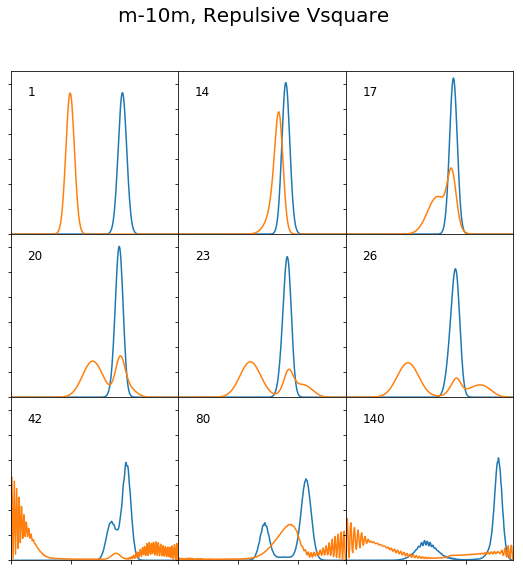

In [64]:
m2 = .5
m1 = 5.
V0 = 100000./2.
V_square = lambda x1, x2: V0*np.heaviside(alpha-np.abs(x1-x2),1)

T_array = np.array([1,14,17,20,23,26,42,80,140])*100
tdse(u0.copy(), v0.copy(), m1, m2, dt, dx, T_array, V_square,'m-10m, Repulsive Vsquare')

Progress: 2.50 %
Progress: 22.50 %
Progress: 32.50 %
Progress: 35.75 %
Progress: 38.75 %
Progress: 42.50 %
Progress: 62.50 %
Progress: 85.00 %
Progress: 100.00 %


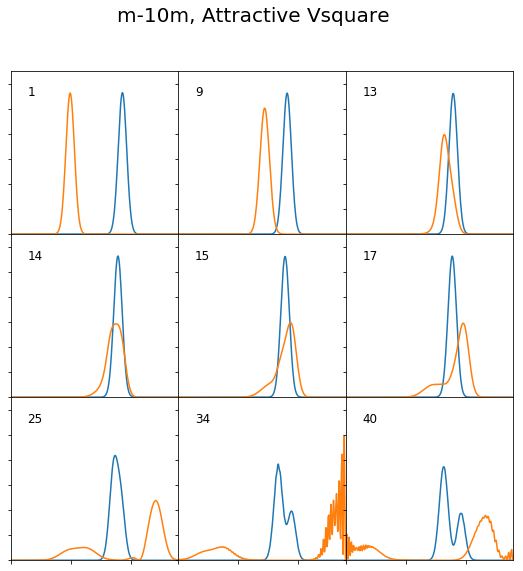

In [94]:
m2 = .5
m1 = 5.
V0 = -100000.*1.3
V_square = lambda x1, x2: V0*np.heaviside(alpha-np.abs(x1-x2),1)

T_array = np.array([1,9,13,14.3,15.5,17,25,34,40])*100
tdse(u0.copy(), v0.copy(), m1, m2, dt, dx, T_array, V_square,'m-10m, Attractive Vsquare')

In [ ]:
m2 = .5
m1 = .5
V0 = -100000.*2
V_square = lambda x1, x2: V0*np.heaviside(alpha-np.abs(x1-x2),1)

T_array = np.array([1,14,17,20,23,26,42,80,140])*100
tdse(u_1, u, v_1, v, m1, m2, dt, dx, T_array, V_square,'m-m, Repulsive Vsquare')

In [ ]:
V_gauss = lambda x1, x2: V0*np.exp(-((x1-x2)**2)/(2*(alpha**2)))
beta = 1.
V_sho = lambda x: beta*(x**2)
V_sq_sho = lambda x1, x2: V_square(x1,x2)+V_sho(x1)+V_sho(x2)